In [1]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import *
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

In [2]:
def naivelm():
    #input term
    infname=input("Enter the data file name: ")
    sep=input("Select the data coding format(1 = 'a b c' or 2 = 'a,b,c'): ")
    if sep=='1':
        form=' '
    elif sep=='2':
        form=','
    else:
        return('You could select only 1 or 2')
    
    hd=input("Select the data header format(1 = with header or 2 = no header): ")
    if hd=='1':
        header='infer'
    elif hd=='2':
        header=None
    else:
        return('You could select only 1 or 2')
 
    cl=input("Select column# where your y vlaues exist: ")
    col = int(cl)-1
    
    data=pd.read_csv(infname,sep=form,header=header)

    #calculate term

    y=data.iloc[:,col]
    x=data.drop(col,1)
    n=data.shape[0]
    p=data.shape[1]
    one=pd.DataFrame(np.ones(n))
    x=pd.concat([one,x],axis=1)

    bhat=inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
    yhat= x.dot(bhat)

    estout=pd.concat([y,yhat],axis=1)

    j=np.ones((n,n))
    sse=y.transpose().dot(y)-bhat.transpose().dot(x.transpose()).dot(y)
    ssto=y.transpose().dot(y) - (1/n)*y.transpose().dot(j).dot(y)

    mse = sse /(n-p)
    rsquared= 1 - ((n-1)/(n-p))*(sse/ssto)
    mseout=pd.DataFrame([mse,rsquared])
    #output and naming term
    """
    outputm=input('Select your output 1:bhat 2:fittedvalue 3:mse&r-squared')
    if(outputm=='1'):
        bhat=pd.DataFrame(bhat)
        b=[]
        for i in bhat.index:
            b.append('Beta' + str(i))
        b[0]='Constant'
        bhat.index=b
        bhat.columns=['Coefficients']
        return(bhat)
    elif(outputm=='2'):
        estout.columns.name = 'ID'
        estout.columns = ['Actual values','Fitted values']
        return(estout)
    elif(outputm=='3'):
        mseout.index=['R-Squared = ','MSE = ']
        mseout.columns=['Model Summary']
        return(mseout)
    else:
        return('You could select only 1,2 or 3')
    """
    bhat=pd.DataFrame(bhat)
    b=[]
    for i in bhat.index:
        b.append('Beta' + str(i))
    b[0]='Constant'
    bhat.index=b
    bhat.columns=['Coefficients']
    estout.columns.name = 'ID'
    estout.columns = ['Actual values','Fitted values']
    mseout.index=['R-Squared = ','MSE = ']
    mseout.columns=['Model Summary']
    output = np.array([bhat,estout,mseout])
    
    fname=input('Select your output file name: ')
    bhat.to_csv(fname, mode='w',sep=' ' ,header=False)
    estout.to_csv(fname, mode='a', header=True)
    mseout.to_csv(fname, mode='a',sep=' ', header=False)
    return(output)
    #print(bhat,'\n', estout, '\n',mseout)


In [3]:
def startlda():
    #input term
    trfname=input("Write your train data file name : ")
    tstfname=input("Write your test data file name : ")
    sep=input("Select the data coding format(1 = 'a b c' or 2 = 'a,b,c'): ")
    if sep=='1':
        form=' '
    elif sep=='2':
        form=','


    hd=input("Select the data header format(1 = with header or 2 = no header): ")
    if hd=='1':
        header='infer'
    elif hd=='2':
        header=None


    cl=input("Select column# where your y vlaues exist: ")
    col = int(cl)-1

    train = pd.read_csv(trfname,sep=form,header=header)
    test = pd.read_csv(tstfname,sep=form,header=header)
    #calculate term

    Y=train.iloc[:,col]
    X=train.drop(col,1)
    n=train.shape[0]
    p=X.shape[1]

    testY=test.iloc[:,col]
    testX=test.drop(col,1)
    testn=test.shape[0]

    g=list(set(Y))
    k=len(g)

    x=[]
    testx=[]
    for i in g:
        x.append(train[train.iloc[:,col]==i].drop(col,1))
    for i in g:
        testx.append(test[test.iloc[:,col]==i].drop(col,1))

    xbar=[]
    for i in range(k):
        xbar.append(x[i].mean(axis=0))

    pw=[]
    for i in range(k):
        pw.append(x[i].shape[0]/n)
    S=[]
    for i in range(k):
        S.append(x[i].cov())
    p=X.shape[1]
    sigma = pd.DataFrame(np.zeros((p,p)))
    for i in range(k):
        sigma = sigma + (x[i].shape[0]-1)*S[i]
    Sp=sigma*(1/(n-k))

    #pred function
    def dk(vec):
        out=[]
        for i in range(k):
            out.append(xbar[i].dot(inv(Sp)).dot(vec) -0.5 * (xbar[i].dot(inv(Sp)).dot(xbar[i].transpose())) + math.log(pw[i]))
        return(out)
    def pred(vec):
        out=pd.DataFrame(g).loc[pd.DataFrame([g,vec]).iloc[1]==max(pd.DataFrame([g,vec]).iloc[1])].iloc[0][0]
        return(out)

    ## resub output
    yhat = []
    for i in range(n):
        yhat.append(pred(dk(X.iloc[i])))

    predy = pd.DataFrame([range(1,(n+1)),Y,yhat]).transpose()
    predy.columns=['ID','Actual class','Resub pred']
    cont = pd.crosstab(predy.iloc[:,1],predy.iloc[:,2])
    acc = sum(np.diag(cont))/n
    #acc = pd.DataFrame(acc)
    
    ## test output
    testyhat = []
    for i in range(testn):
        testyhat.append(pred(dk(testX.iloc[i])))

    tpredy = pd.DataFrame([range(1,(testn+1)),testY,testyhat]).transpose()
    tpredy.columns=['ID','Actual class','Test pred']
    tcont = pd.crosstab(tpredy.iloc[:,1],tpredy.iloc[:,2])
    tacc = sum(np.diag(tcont))/testn
    #tacc=pd.DataFrame(tacc)

    fname = input('Write your output file name : ')
    #console output
    print(predy.to_string(index=False))
    print(cont)
    print("Overall accuracy = %0.3f" %(acc))

    print(tpredy.to_string(index=False))
    print(tcont)
    print("Overall accuracy = %0.3f" %(tacc))
    
    #file output
    out = open(fname, 'w')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(predy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Resubstitution)",file=out)
        print(cont,file=out)
        print("",file=out)
        print("Model Summary (Resubstitution)",file=out)
        print("Overall accuracy = %0.3f" %(acc),file=out)
        print("",file=out)
        print(tpredy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Test)",file=out)
        print(tcont,file=out)
        print("",file=out)
        print("Model Summary (Test)",file=out)
        print("Overall accuracy = %0.3f" %(tacc),file=out)
    out.close()

In [4]:
def startqda():
    #input term
    trfname=input("Write your train data file name : ")
    tstfname=input("Write your test data file name : ")
    sep=input("Select the data coding format(1 = 'a b c' or 2 = 'a,b,c'): ")
    if sep=='1':
        form=' '
    elif sep=='2':
        form=','


    hd=input("Select the data header format(1 = with header or 2 = no header): ")
    if hd=='1':
        header='infer'
    elif hd=='2':
        header=None


    cl=input("Select column# where your y vlaues exist: ")
    col = int(cl)-1

    train = pd.read_csv(trfname,sep=form,header=header)
    test = pd.read_csv(tstfname,sep=form,header=header)
    #calculate term

    Y=train.iloc[:,col]
    X=train.drop(col,1)
    n=train.shape[0]
    p=X.shape[1]

    testY=test.iloc[:,col]
    testX=test.drop(col,1)
    testn=test.shape[0]

    g=list(set(Y))
    k=len(g)

    x=[]
    testx=[]
    for i in g:
        x.append(train[train.iloc[:,col]==i].drop(col,1))
    for i in g:
        testx.append(test[test.iloc[:,col]==i].drop(col,1))

    xbar=[]
    for i in range(k):
        xbar.append(x[i].mean(axis=0))

    pw=[]
    for i in range(k):
        pw.append(x[i].shape[0]/n)
    S=[]
    for i in range(k):
        S.append(x[i].cov())
    p=X.shape[1]
    sigma = pd.DataFrame(np.zeros((p,p)))
    for i in range(k):
        sigma = sigma + (x[i].shape[0]-1)*S[i]
    Sp=sigma*(1/(n-k))

    #pred function
    def dk(vec):
        out=[]
        for i in range(k):
            out.append(-0.5*(math.log(det(S[i])))-0.5*((vec-xbar[i]).dot(inv(S[i])).dot((vec-xbar[i]).transpose())) +math.log(pw[i]))
            #out.append(xbar[i].dot(inv(Sp)).dot(vec) -0.5 * (xbar[i].dot(inv(Sp)).dot(xbar[i].transpose())) + math.log(pw[i]))
        return(out)
    def pred(vec):
        out=pd.DataFrame(g).loc[pd.DataFrame([g,vec]).iloc[1]==max(pd.DataFrame([g,vec]).iloc[1])].iloc[0][0]
        return(out)

    ## resub output
    yhat = []
    for i in range(n):
        yhat.append(pred(dk(X.iloc[i])))

    predy = pd.DataFrame([range(1,(n+1)),Y,yhat]).transpose()
    predy.columns=['ID','Actual class','Resub pred']
    cont = pd.crosstab(predy.iloc[:,1],predy.iloc[:,2])
    acc = sum(np.diag(cont))/n

    ## test output
    testyhat = []
    for i in range(testn):
        testyhat.append(pred(dk(testX.iloc[i])))

    tpredy = pd.DataFrame([range(1,(testn+1)),testY,testyhat]).transpose()
    tpredy.columns=['ID','Actual class','Test pred']
    tcont = pd.crosstab(tpredy.iloc[:,1],tpredy.iloc[:,2])
    tacc = sum(np.diag(tcont))/testn


    fname = input('Write your output file name : ')
    #console output
    print(predy.to_string(index=False))
    print(cont)
    print("Overall accuracy = %0.3f" %(acc))

    print(tpredy.to_string(index=False))
    print(tcont)
    print("Overall accuracy = %0.3f" %(tacc))
    
    #file output
    out = open(fname, 'w')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(predy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Resubstitution)",file=out)
        print(cont,file=out)
        print("",file=out)
        print("Model Summary (Resubstitution)",file=out)
        print("Overall accuracy = %0.3f" %(acc),file=out)
        print("",file=out)
        print(tpredy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Test)",file=out)
        print(tcont,file=out)
        print("",file=out)
        print("Model Summary (Test)",file=out)
        print("Overall accuracy = %0.3f" %(tacc),file=out)
    out.close()

In [5]:
def startrda():
    #input term
    trfname=input("Write your train data file name : ")
    tstfname=input("Write your test data file name : ")
    sep=input("Select the data coding format(1 = 'a b c' or 2 = 'a,b,c'): ")
    if sep=='1':
        form=' '
    elif sep=='2':
        form=','


    hd=input("Select the data header format(1 = with header or 2 = no header): ")
    if hd=='1':
        sh=1
    elif hd=='2':
        sh=0


    cl=input("Select column# where your y vlaues exist: ")
    col = int(cl)-1

    train = np.genfromtxt(trfname, delimiter=form, skip_header=sh)
    test = np.genfromtxt(tstfname, delimiter=form, skip_header=sh)

    #calculate term
    X = np.delete(train, col, 1) # input variable
    Y = train[:,col] # target variable

    n = len(train) # number of obs
    p = X.shape[1] # number of variables

    testX = np.delete(test, col, 1) # input variable
    testY = test[:,col] # target variable

    g = np.array(list(set(Y))) # unique value of target variable
    k = len(g) # number of unique values

    #calculate mean of each variables by y values
    tmp=[]
    for i in g:
        tmp.append(X[np.where(train[:,col]==i)])
    xby = np.array(tmp)
    xbar = np.array(list(map(lambda x : np.mean(x,axis=0),xby)))

    #prior probability
    pw=[]
    for i in range(k):
        pw.append(xby[i].shape[0]/n)
    pw = np.array(pw)

    #np.cov(xby[0].transpose())
    S0 = np.array(list(map(lambda x : np.cov(x.transpose()) , xby)))

    # ready for calculate covariance matrix
    sigma =np.zeros((p,p))
    for i in range(k):
        sigma = sigma + (xby[i].shape[0]-1)*S0[i]
    Sp=sigma*(1/(n-k))
    
    def dk(vec, S = S0):
        out=[]
        for i in range(k):
            out.append(-0.5*(math.log(det(S[i])))-0.5*((vec-xbar[i]).dot(inv(S[i])).dot((vec-xbar[i]).transpose())) +math.log(pw[i]))
        return(out)
    
    def dk2(vec, S = S0):
        out=[]
        for i in range(k):
            out.append(-0.5*(math.log(det(S[i])))-0.5*np.diag((vec-xbar[i]).dot(inv(S[i])).dot((vec-xbar[i]).transpose())) +math.log(pw[i]))
        return(out)
    def pred(vec):
        out=pd.DataFrame(g).loc[pd.DataFrame([g,vec]).iloc[1]==max(pd.DataFrame([g,vec]).iloc[1])].iloc[0][0]
        return(out)

    tp = np.array(list(map(dk,X)))
    yhat = np.argmax(tp,axis =1)
    cont = pd.crosstab(Y,yhat)
    acc = sum(np.diag(cont))/n

    #ready for grid search
    s2=np.diag(Sp).mean()

    def getacc(Sk ,a,r):
        Sar = a*Sk + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))
        tp2 = np.array(dk2(testX,Sar)).reshape(k,len(testX)).transpose()
        yhatg = np.argmax(tp2,axis =1)
        contg = pd.crosstab(testY,yhatg)
        acc2 = sum(np.diag(contg))/len(test)
        return(acc2)

    df = pd.DataFrame()
    gridseed=21
    for i in range(gridseed):
        df=df.append(pd.DataFrame(np.zeros(gridseed)).transpose())
    alpha = gamma = list(map(lambda x : x/(gridseed-1) , list(range(gridseed))))
    df.columns=alpha
    df.index=gamma
    for a ,i in zip(alpha , range(gridseed)):
        for r, j in zip(gamma, range(gridseed)) :
            df.iloc[i,j]= getacc(S0,a,r)
    #get the optimized value of alpha & gamma (alpha = 0.53, beta = 1)
    argm=df.stack().index[np.argmax(df.values)]
    a = argm[0]
    r = argm[1]
    Snew = a*S0 + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))

    #resub output
    tp = np.array(list(map(lambda x : dk(x,Snew),X)))
    yhat = np.argmax(tp,axis =1)
    cont = pd.crosstab(Y,yhat)
    acc = sum(np.diag(cont))/n

    #test output
    ttp = np.array(list(map(lambda x : dk(x,Snew),testX)))
    tyhat = np.argmax(ttp,axis =1)
    tcont = pd.crosstab(testY,tyhat)
    tacc = sum(np.diag(tcont))/len(test)


    predy = pd.DataFrame([range(1,(len(train)+1)),Y,yhat]).transpose()
    predy.columns=['ID','Actual class','Resub pred']

    tpredy = pd.DataFrame([range(1,(len(test)+1)),testY,tyhat]).transpose()
    tpredy.columns=['ID','Actual class','Test pred']

    cont.columns = g
    cont.index = g
    cont.columns.name = 'Resub Class'
    cont.index.name = 'Actual Class'

    tcont.columns = g
    tcont.index = g
    tcont.columns.name = 'Prediction Class'
    tcont.index.name = 'Actual Class'

    fname = input('Write your output file name : ')
    #plotting
    x = df.columns
    y = df.index
    X,Y = np.meshgrid(x,y)
    Z = df
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)
    plt.show()
    
    #console output
    print(predy.to_string(index=False))
    print(cont)
    print("Overall accuracy = %0.3f" %(acc))

    print(tpredy.to_string(index=False))
    print(tcont)
    print("Overall accuracy = %0.3f" %(tacc))
    
    #file output
    out = open(fname, 'w')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(predy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Resubstitution)",file=out)
        print(cont,file=out)
        print("",file=out)
        print("Model Summary (Resubstitution)",file=out)
        print("Overall accuracy = %0.3f" %(acc),file=out)
        print("",file=out)
        print(tpredy.to_string(index=False),file=out)
        print("",file=out)
        print("Confusion Matrix (Test)",file=out)
        print(tcont,file=out)
        print("",file=out)
        print("Model Summary (Test)",file=out)
        print("Overall accuracy = %0.3f" %(tacc),file=out)
    out.close()

In [6]:
def startclf():
    inp = input('Select Classification model 1 = LDA , 2 = QDA, 3 = RDA : ')
    if inp=='1':
        return(startlda())
    elif inp=='2':
        return(startqda())
    elif inp=='3':
        return(startrda())

In [7]:
def start():
    inp = input('Select model 1 = Linear regression , 2 = Classification : ')
    if inp=='1':
        return(naivelm())
    if inp=='2':
        return(startclf())

Select model 1 = Linear regression , 2 = Classification : 2
Select Classification model 1 = LDA , 2 = QDA, 3 = RDA : 3
Write your train data file name : veh.dat
Write your test data file name : vehtest.dat
Select the data coding format(1 = 'a b c' or 2 = 'a,b,c'): 2
Select the data header format(1 = with header or 2 = no header): 2
Select column# where your y vlaues exist: 19
Write your output file name : oo


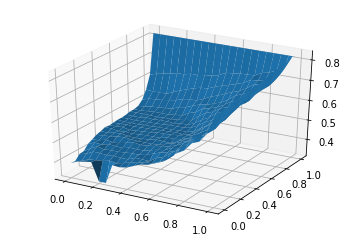

ID  Actual class  Resub pred
  1.0           1.0         0.0
  2.0           1.0         0.0
  3.0           1.0         0.0
  4.0           1.0         0.0
  5.0           1.0         0.0
  6.0           1.0         0.0
  7.0           1.0         0.0
  8.0           1.0         0.0
  9.0           1.0         0.0
 10.0           1.0         0.0
 11.0           1.0         1.0
 12.0           1.0         0.0
 13.0           1.0         0.0
 14.0           1.0         0.0
 15.0           1.0         0.0
 16.0           1.0         0.0
 17.0           1.0         0.0
 18.0           1.0         0.0
 19.0           1.0         0.0
 20.0           1.0         0.0
 21.0           1.0         0.0
 22.0           2.0         1.0
 23.0           2.0         1.0
 24.0           2.0         1.0
 25.0           2.0         1.0
 26.0           2.0         1.0
 27.0           2.0         1.0
 28.0           2.0         1.0
 29.0           2.0         1.0
 30.0           2.0         1.0
 31.0      

In [8]:
start()